<a href="https://colab.research.google.com/github/syedshubha/PulseSCQ/blob/main/W_state_Pulse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#$|W\rangle = \frac{1}{\sqrt{3}}(\left|001\rangle+|010\rangle+|100\rangle\right)$


In [5]:
from google.colab import files
uploaded = files.upload()

import json
with open("wstate_backend_params.json", "r") as f:
    backend_data = json.load(f)

dt = backend_data["dt"]
params = backend_data["parameters"]

Saving wstate_backend_params.json to wstate_backend_params (1).json


In [6]:
dt = backend_data["dt"]
params = backend_data["parameters"]
physical_qubits = [1, 2, 3]

# Define pulse-level constants
sigma = 64
duration = 128
meas_duration = 512
meas_amp = 0.3
cr_amp = 0.2
cr_duration = 256
gate_time = duration * dt


drive_freqs = {int(k)-1: v["DF"] for k, v in params.items()}  # maps 0,1,2 to DF
logical_to_physical = {0: 1, 1: 2, 2: 3}

# Pulse Level

In [ ]:
!pip install --quiet \
  "qiskit==0.46.0" \
  "qiskit-terra==0.46.0" \
  "qiskit-aer==0.13.0" \
  "qiskit-ibm-runtime==0.20.0" \
  "qiskit-dynamics==0.3.0" \
  pylatexenc &> /dev/null

In [ ]:
from qiskit import QuantumCircuit, transpile, pulse
from qiskit.pulse import DriveChannel, Gaussian
from qiskit.circuit import Gate
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error, ReadoutError
from qiskit.pulse import DriveChannel, shift_phase, play, build, MeasureChannel, AcquireChannel, MemorySlot
from qiskit.pulse.library import Gaussian, Constant
import numpy as np
import matplotlib.pyplot as plt
from math import pi, acos, sqrt

##Pulse-Level Calibration

▶ Calibrating Rabi on physical Q1
   → π_amp ≃ 0.9806
▶ Calibrating Rabi on physical Q2
   → π_amp ≃ 0.9612
▶ Calibrating Rabi on physical Q3
   → π_amp ≃ 1.0000


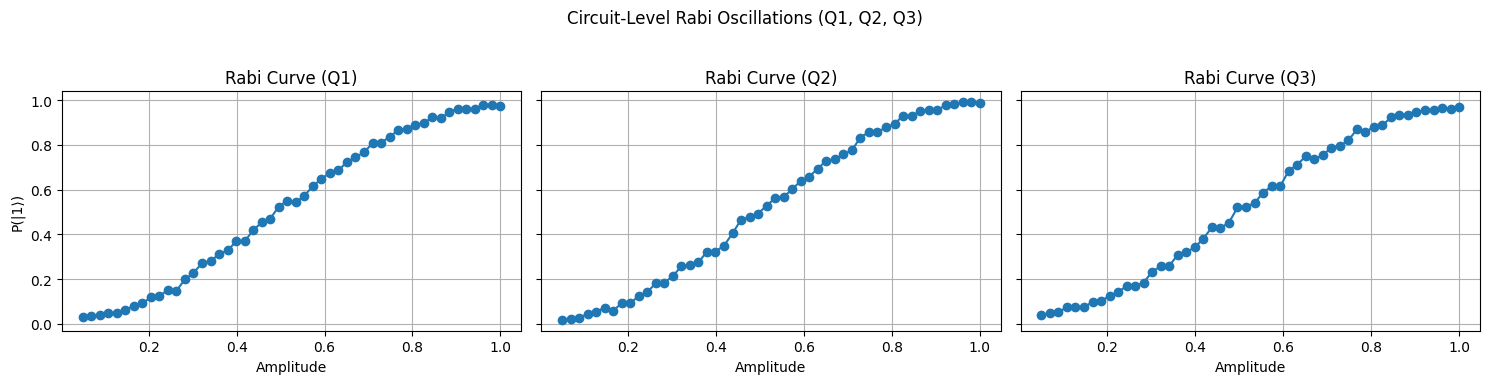

In [ ]:
amplitudes = np.linspace(0.05, 1.0, 50)

# prepare subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
pi_amps = {}

# ─── Loop over each physical qubit ───
for idx, q_phys in enumerate(physical_qubits):
    print(f"▶ Calibrating Rabi on physical Q{q_phys}")

    nm = NoiseModel()
    p = params[str(q_phys)]  # JSON keys are strings

    # thermal relaxation on the one qubit:
    nm.add_quantum_error(
        thermal_relaxation_error(p['T1'], p['T2'], gate_time),
        ['rx'], [0]
    )
    # readout error on that qubit
    nm.add_readout_error(
        ReadoutError([[1 - p['RO'], p['RO']],
                      [p['RO'], 1 - p['RO']]]),
        [0]
    )

    sim = AerSimulator(noise_model=nm, method='statevector')

    probs = []
    for amp in amplitudes:
        theta = amp * np.pi
        qc = QuantumCircuit(1, 1)
        qc.rx(theta, 0)        # rotate by θ
        qc.measure(0, 0)
        result = sim.run([qc], shots=1024).result()
        counts = result.get_counts(0)
        p1 = counts.get('1', 0) / 1024
        probs.append(p1)

    ax = axes[idx]
    ax.plot(amplitudes, probs, 'o-')
    ax.set_title(f"Rabi Curve (Q{q_phys})")
    ax.set_xlabel("Amplitude")
    if idx == 0:
        ax.set_ylabel("P(|1⟩)")
    ax.grid(True)

    best = amplitudes[np.argmax(probs)]
    pi_amps[q_phys] = best
    print(f"   → π_amp ≃ {best:.4f}")

plt.suptitle("Circuit-Level Rabi Oscillations (Q1, Q2, Q3)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Define Calibrated Gates

In [ ]:
# Pulse building blocks
def ry_sched(theta, phys_q, A_pi):
    amp = A_pi * (theta / pi)
    with build(name=f"ry({theta:.2f})_q{phys_q}") as sched:
        shift_phase(pi/2, DriveChannel(phys_q - 1))
        play(Gaussian(duration, amp, sigma), DriveChannel(phys_q - 1))
        shift_phase(-pi/2, DriveChannel(phys_q - 1))
    return sched

def x_sched(phys_q, A_pi):
    with build(name=f"x_q{phys_q}") as sched:
        play(Gaussian(duration, A_pi, sigma), DriveChannel(phys_q - 1))
    return sched

def cx_sched(control, target, amp=cr_amp, cr_duration=cr_duration):
    with build(name=f"cx_{control}_{target}", default_alignment="sequential") as sched:
        # Control drives at target’s frequency
        pulse.set_frequency(drive_freqs[target - 1], DriveChannel(control - 1))
        # First CR pulse
        pulse.play(Gaussian(cr_duration, amp, cr_duration / 4), DriveChannel(control - 1))
        # Echo on target (π pulse)
        pulse.play(Gaussian(duration, pi_amps[target], sigma), DriveChannel(target - 1))
        # Second CR pulse (negative amp)
        pulse.play(Gaussian(cr_duration, -amp, cr_duration / 4), DriveChannel(control - 1))
    return sched

def measure_sched(phys_q):
    with build(name=f"measure_q{phys_q}") as sched:
        pulse.play(Constant(meas_duration, meas_amp), MeasureChannel(phys_q - 1))
        pulse.acquire(meas_duration, AcquireChannel(phys_q - 1), MemorySlot(0))
    return sched

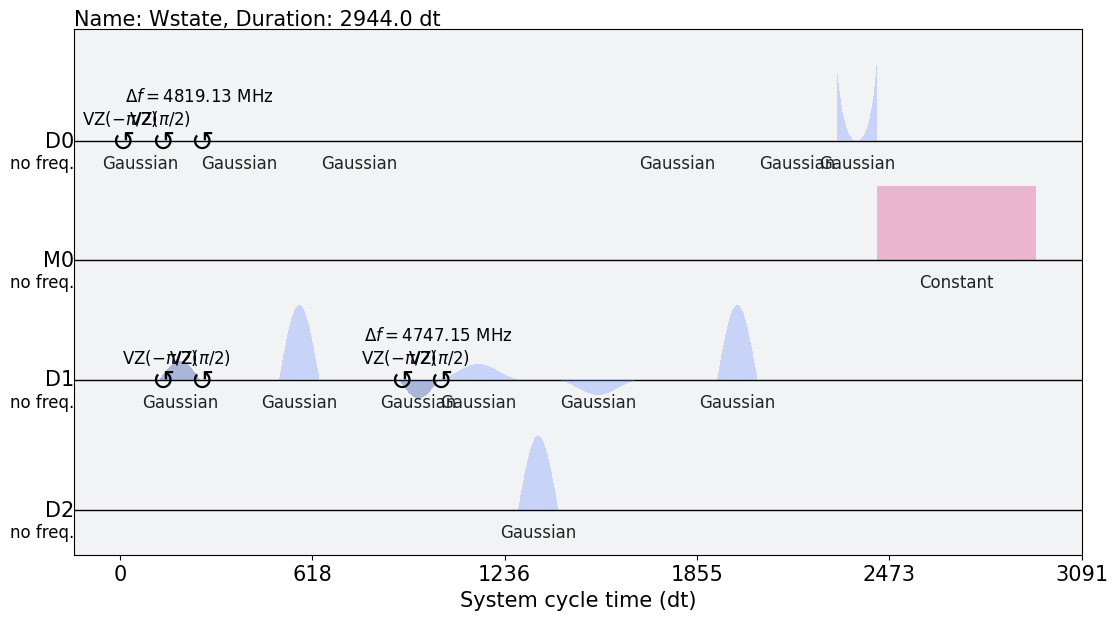

In [ ]:
A_pi = pi_amps

# Build the full circuit
with build(name="Wstate", default_alignment="sequential") as full_sched:
    # RY(2*acos(1/sqrt(3))) on q0 → Q1
    full_sched.append(ry_sched(2 * acos(1 / sqrt(3)), 1, A_pi[1]))

    # RY(pi/4) on q1 → Q2
    full_sched.append(ry_sched(pi/4, 2, A_pi[2]))

    # CX(0,1) → Q1→Q2
    full_sched.append(cx_sched(1, 2))

    # RY(-pi/4) on q1 → Q2
    full_sched.append(ry_sched(-pi/4, 2, A_pi[2]))

    # CX(1,2) → Q2→Q3
    full_sched.append(cx_sched(2, 3))

    # CX(0,1) again → Q1→Q2
    full_sched.append(cx_sched(1, 2))

    # X on q0 → Q1
    full_sched.append(x_sched(1, A_pi[1]))

    # Measure q0 → Q1
    full_sched.append(measure_sched(1))

from qiskit.pulse.library import Waveform
Waveform.limit_amplitude = False

full_sched.draw()

In [ ]:
drawer = full_sched.draw()
drawer.figure.savefig("full_sched_high_res.png", dpi=500, bbox_inches="tight")